In [1]:
using ProfileView
using Distributions
using GLM
using StatsBase
using PyCall
using PyPlot

In [38]:
function create_bitpop_triange(Nsnp::Int, Nind::Int)
    res = bitpack(zeros(Bool, Nsnp, 2Nind))
    for i in 1:2Nind
        for j in 0:(i-1)
            res[j%Nsnp+1,i] = !res[j%Nsnp+1,i] 
        end
    end
    res
end

function create_bitpop_random(Nsnp::Int, Nind::Int)
    res = BitArray{2}(Nsnp,2Nind)
    for i in 1:2Nind
        res[:,i] = rand(Nsnp).<0.5
    end
    res
end

function create_bitpop_banded(Nsnp::Int, Nind::Int)
    res = BitArray{2}(Nsnp,2Nind)
    for i in 1:size(res)[2]
        if i%2 == 0
            res[:,i]=true
        else
            res[:,i]=false
        end
    end
    res
end

function iterate!(pop::AbstractArray{Bool}, selected_alleles::Vector{Int}, sortedunique::Vector{Int})
    temp = pop[:,sortedunique]
    for (i, j) in enumerate(selected_alleles)
        tempidx = findfirst(sortedunique, j)
        pop[:,i] = temp[:,tempidx]
    end
    pop
end

function crossover_chr!(pop::AbstractArray{Bool}, ind::Int, crossoverindex::Int)
    temp = pop[crossoverindex:end,ind] 
    pop[crossoverindex:end,ind] = pop[crossoverindex:end,ind+1]
    pop[crossoverindex:end,ind+1] = temp
    return pop
end

function crossover!(pop::AbstractArray{Bool}, hotspots::Vector{Int}, sortedunique::Vector{Int}) 
    for i in unique(Int[iseven(j)? j-1:j for j in sortedunique])
        crossoverindex = sample(hotspots)
        crossover_chr!(pop, i, crossoverindex)
    end
end

function mutate_column!(pop::AbstractArray{Bool}, column::Int, mutationrate::Float64)
    Nsnp = size(pop)[1]
    selected = find(rand(Nsnp) .< mutationrate)
    for s in selected
        pop[s,column] = !pop[s,column]
    end
    return pop
end

function mutate!(pop::AbstractArray{Bool}, mutationrate::Float64, sortedunique::Vector{Int})
    Ncolumns = size(pop)[2]
    for i in sortedunique
        mutate_column!(pop, i, mutationrate)
    end
    return pop
end

function calc_dosage(pop::AbstractArray{Bool})
    Nsnp = size(pop)[1]
    Nind = Int(size(pop)[2]/2)
    dose = zeros(Int, Nsnp, Nind)
    for i in 1:Nind
        dose[:,i] = pop[:,2*i-1] + pop[:,2*i] 
    end 
    dose
end

function corr(pop::AbstractArray{Bool}, i,j)
    Ncol = size(pop)[2]      
    pi = 1.* sum(pop[i,:]) / Ncol
    pj = 1.* sum(pop[j,:]) / Ncol
    pij = 1.* sum(pop[j,:].*pop[i,:]) / Ncol
    (pij - pi*pj) / sqrt(pi*(1-pi) * pj *(1-pj))
end

function zygotefreq(dosage)
    Nsnp = size(dosage)[1]
    Nind = size(dosage)[2]
    res = zeros(Float64, 3, Nsnp)
    for i in 1:Nsnp
        res[:, i] = counts(dosage[i,:],0:2) / Nind
    end
    res'
end

function heterozygote(pop::AbstractArray{Bool})
    zf = zygotefreq(calc_dosage(pop))
    pHW = sqrt(zf[:,1])
    Float64[zf[2] 2*pHW.*(1-pHW)]
end

function heterozygote_HW(dosage)
    p = sqrt(zygotefreq(dosage)[:,1])
    2*p.*(1-p)
end

function showmatrix(matrix;minmax=[0,1], cmap="binary")
    fig = plt[:figure]()
    ax = fig[:add_axes]([0,0,1,1])
    ax[:imshow](matrix,interpolation="nearest",cmap=cmap, vmin=minmax[1], vmax=minmax[2])
    ax[:axis]("off")
    ax
end

function evolve_sample(pop::AbstractArray{Bool}, Niter::Int; 
                       hotspots::Vector{Int}=[], mutationrate::Float64=-1)
    
    Nsnp = size(pop)[1]
    Nind = Int(size(pop)[2]/2)

    for i in 1:Niter
        selected_alleles = sample(1:2Nind,2Nind)
        sortedunique = sort!(unique(selected_alleles))
        iterate!(pop, selected_alleles, sortedunique)
        
        if length(hotspots)>0
            crossover!(pop, hotspots, sortedunique)
        end
        if mutationrate>0
            mutate!(pop, mutationrate, sortedunique)
        end
    end
    pop
end

function make_sample(Nsnp, Nind, Niter, Nhs, mutationrate; initials_sample=create_bitpop_random)
    pop = initials_sample(Nsnp, Nind)
    hotspots = sample(2:Nsnp,Nhs)
    evolve_sample(pop, Niter, hotspots=hotspots, mutationrate=mutationrate)
    # returns pop after iterations
end

function zhist(zscores)
    x = collect(linspace(-3.5,3.5,40))
    BLUE = "#348ABD"
    RED = "#A60628"
    fig = plt[:figure](figsize=(5,3))
    ax = fig[:add_subplot](111)
    ax[:hist](zscores, bins=x, color=BLUE, ec="white",normed=1)
    ax[:plot](x, pdf(Normal(),x),"--",color=RED, lw=2)
    ax[:set_ylim]([0,0.5])
    ax[:set_xlim]([x[1],x[end]])
end

function manhattanplot(zscores, snpnumber)
    RED = "#A60628"
    log = log10
    
    neglogp = -log(calcpvals(zscores))
    Bonf1 = -log(0.05/length(snpnumber))
    Bonf2 = -log(0.01/length(snpnumber))
    range = [snpnumber[1],snpnumber[end]]

    fig = plt[:figure](figsize=(5,3))
    ax = fig[:add_subplot](111)
    ax[:plot](snpnumber, neglogp, "xk")
    ax[:plot](range, [Bonf2, Bonf2], "--", color=RED)
    ax[:plot](range, [Bonf1, Bonf1], ":", color=RED)

    ax[:set_ylim]([0,9])
    ax[:set_xlim](range)


end

function GWAS(pop::AbstractArray{Bool}, casecontrol)
    dosT = dosage(pop)' # each column corresponds to snp
    (Nind, Nsnp) = size(dosT)
    
    snpvec = collect(1:Nsnp)
    zscores = Vector{Float64}(Nsnp)

    one_vec = ones(Nind)
    for i in 1:Nsnp
        try
            logit = glm(Float64[one_vec dosT[:,i]], casecontrol, Binomial(), LogitLink())
            zscores[i] = coef(logit)[2] / stderr(logit)[2]
        catch
            # set unvalid
            snpvec[i] = -1 
        end
    end
    snpvec = snpvec[snpvec.>0]
    
    (zscores[snpvec], snpvec)
end
calcpvals(zscores) = Float64[ccdf(Normal(), abs(z)) for z in zscores]

calcpvals (generic function with 1 method)

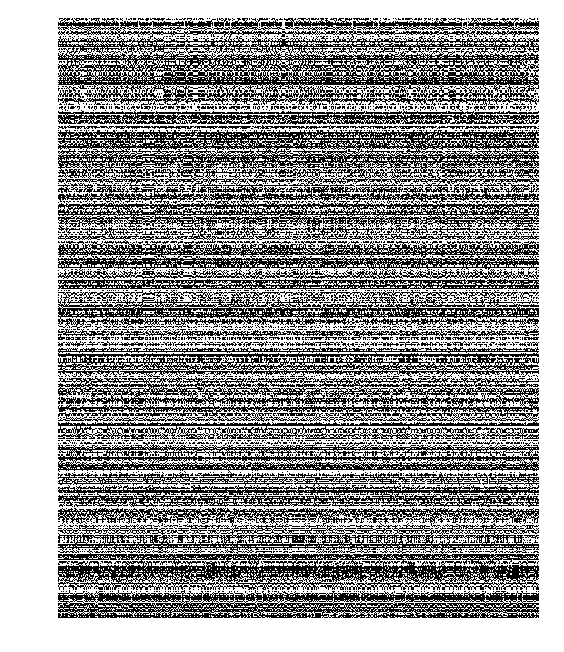

PyObject <matplotlib.axes._axes.Axes object at 0x326af26d8>

In [3]:
Nsnp  = 1000
Nind  = 400
Niter = 1000
Nhs   = 10
mrate = 0.001

pop = make_sample(Nsnp,Nind,Niter,Nhs,mrate)
showmatrix(pop)

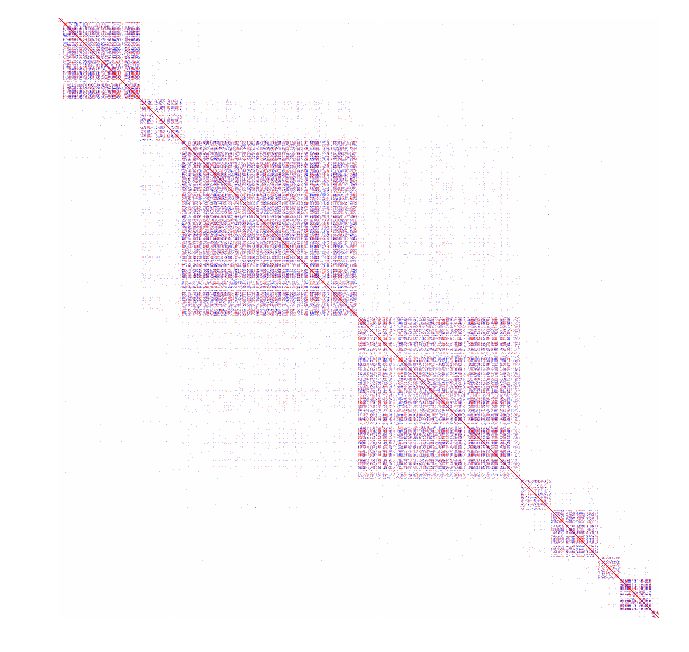

PyObject <matplotlib.axes._axes.Axes object at 0x32687e320>

In [4]:
cormat = cor(pop,2)
cormat[abs(cormat).<0.2] = 0
showmatrix(cormat,cmap="bwr", minmax=[-1,1])

@time make_sample(Nsnp,Nind,Niter,Nhs,mrate)
Profile.clear()
@profile make_sample(Nsnp,Nind,Niter,Nhs,mrate)
ProfileView.view()

In [5]:
prevalence = 0.1
casecontrol = rand(Nind).<prevalence;


(zscores,snpvec) = GWAS(pop, casecontrol)




([0.623549,-1.11985,-0.697199,0.564396,0.220307,-0.33172,0.449287,1.0731,0.0962495,1.06117  …  0.0375722,0.445386,0.347513,1.43404,0.603318,0.906956,-1.28797,0.996472,0.3242,-0.124899],[1,2,3,4,5,6,7,8,9,10  …  991,992,993,994,995,996,997,998,999,1000])

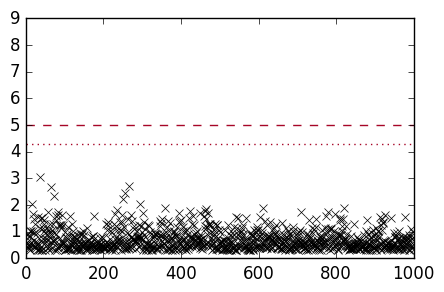

(1,1000)

In [42]:
manhattanplot(zscores, snpvec)

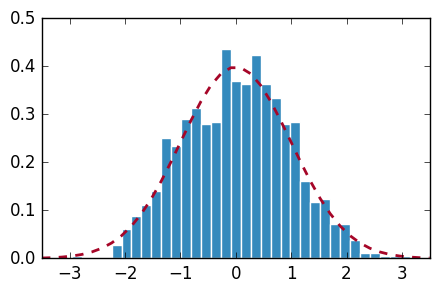

(-3.5,3.5)

In [41]:
zhist(zscores)

In [ ]:
collect(linspace(-4,4))

In [29]:
[3]

LoadError: LoadError: syntax: use "^" instead of "**"
while loading In[29], in expression starting on line 1